**Step 1: Setup and dataset download (Kaggle)**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "your_kaggle_username",\r\n  "key": "KGAT_54b0da956da86383fb999fafe70710b6"\r\n}\r\n'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hiteshsoneji/historical-weather-data-for-indian-cities
!unzip historical-weather-data-for-indian-cities.zip

Dataset URL: https://www.kaggle.com/datasets/hiteshsoneji/historical-weather-data-for-indian-cities
License(s): other
  0% 0.00/11.8M [00:00<?, ?B/s]
100% 11.8M/11.8M [00:00<00:00, 1.51GB/s]


**Step 2: Spark session and merge all city CSVs**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

spark = SparkSession.builder.appName("MultiCityWeather").getOrCreate()

# List of city file basenames (ensure these files exist in /content)
cities = ["jaipur","delhi","bombay","bengaluru","hyderabad","pune","kanpur","nagpur"]

dfs = []
for city in cities:
    df = spark.read.csv(f"/content/{city}.csv", header=True, inferSchema=True)
    df = df.withColumn("city", lit(city))
    dfs.append(df)

# Union all cities into one DataFrame
weather_df = dfs[0]
for df in dfs[1:]:
    weather_df = weather_df.union(df)

# Quick check
weather_df.show(5)
weather_df.printSchema()


+-------------------+--------+--------+------------+-------+--------+--------+-----------------+--------+--------+--------+--------+---------+----------+----------+----------+------------+----------+--------+--------+--------+-----+----------+-------------+-------------+------+
|          date_time|maxtempC|mintempC|totalSnow_cm|sunHour|uvIndex5|uvIndex6|moon_illumination|moonrise| moonset| sunrise|  sunset|DewPointC|FeelsLikeC|HeatIndexC|WindChillC|WindGustKmph|cloudcover|humidity|precipMM|pressure|tempC|visibility|winddirDegree|windspeedKmph|  city|
+-------------------+--------+--------+------------+-------+--------+--------+-----------------+--------+--------+--------+--------+---------+----------+----------+----------+------------+----------+--------+--------+--------+-----+----------+-------------+-------------+------+
|2009-01-01 00:00:00|      24|       8|         0.0|    8.7|       4|       1|               31|10:15 AM|10:03 PM|07:16 AM|05:45 PM|        1|        11|        12

**Step 3: Preprocessing (clean and cast)**

In [ ]:
from pyspark.sql.functions import col

# Drop nulls in key columns (adjust if your dataset uses different names)
weather_df = weather_df.dropna(subset=["tempC","humidity","pressure","windspeedKmph","precipMM"])

# Cast timestamp
weather_df = weather_df.withColumn("date_time", col("date_time").cast("timestamp"))

# Optional: filter year range (change or remove as needed)
# weather_df = weather_df.filter(col("date_time") >= "2015-01-01")

# Diagnostics
print("Rows:", weather_df.count())
weather_df.printSchema()
weather_df.show(5)


Rows: 771456
root
 |-- date_time: timestamp (nullable = true)
 |-- maxtempC: integer (nullable = true)
 |-- mintempC: integer (nullable = true)
 |-- totalSnow_cm: double (nullable = true)
 |-- sunHour: double (nullable = true)
 |-- uvIndex5: integer (nullable = true)
 |-- uvIndex6: integer (nullable = true)
 |-- moon_illumination: integer (nullable = true)
 |-- moonrise: string (nullable = true)
 |-- moonset: string (nullable = true)
 |-- sunrise: string (nullable = true)
 |-- sunset: string (nullable = true)
 |-- DewPointC: integer (nullable = true)
 |-- FeelsLikeC: integer (nullable = true)
 |-- HeatIndexC: integer (nullable = true)
 |-- WindChillC: integer (nullable = true)
 |-- WindGustKmph: integer (nullable = true)
 |-- cloudcover: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- precipMM: double (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- tempC: integer (nullable = true)
 |-- visibility: integer (nullable = true)
 |-- winddirDegree: int

**Step 4: Basic exploratory plots (cleaned data)**

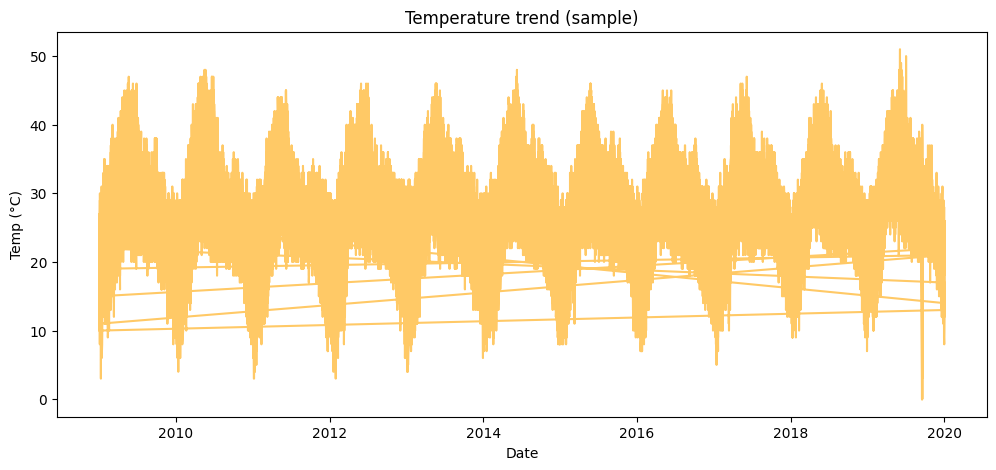

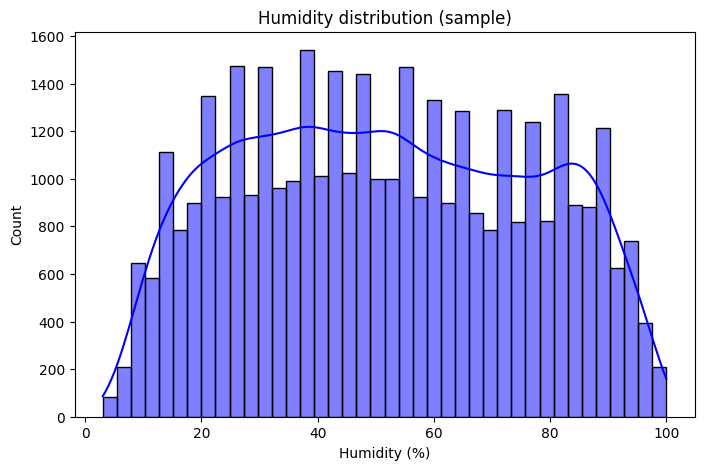

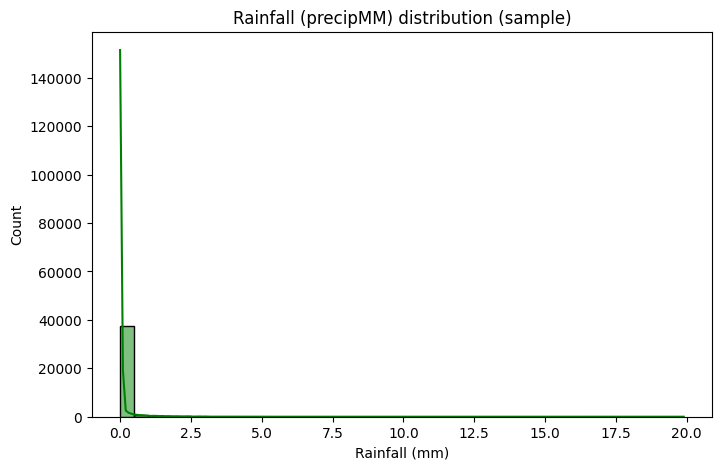

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample to Pandas for plotting (adjust fraction for speed/quality)
pdf = weather_df.sample(False, 0.05, seed=42).toPandas()

# Temperature trend (all cities mixed)
plt.figure(figsize=(12,5))
plt.plot(pdf["date_time"], pdf["tempC"], color="orange", alpha=0.6)
plt.title("Temperature trend (sample)")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.show()

# Humidity distribution
plt.figure(figsize=(8,5))
sns.histplot(pdf["humidity"], bins=40, kde=True, color="blue")
plt.title("Humidity distribution (sample)")
plt.xlabel("Humidity (%)")
plt.show()

# Rainfall distribution (precipMM)
plt.figure(figsize=(8,5))
sns.histplot(pdf["precipMM"], bins=40, kde=True, color="green")
plt.title("Rainfall (precipMM) distribution (sample)")
plt.xlabel("Rainfall (mm)")
plt.show()

**Step 5: Feature engineering (month, day, hour) and exploratory plots**

/tmp/ipython-input-1679015317.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="month", y="tempC", data=pdf_feat, palette="Oranges")


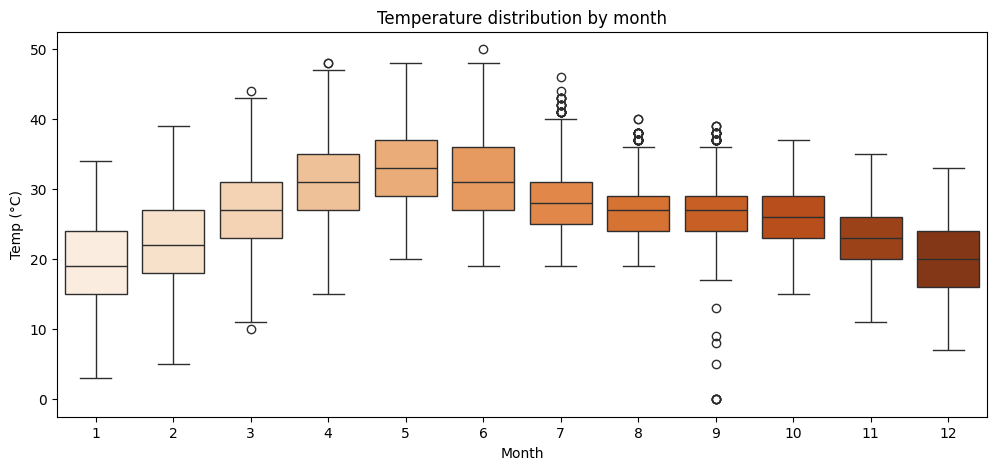

/tmp/ipython-input-1679015317.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="hour", y="humidity", data=pdf_feat, palette="Blues")


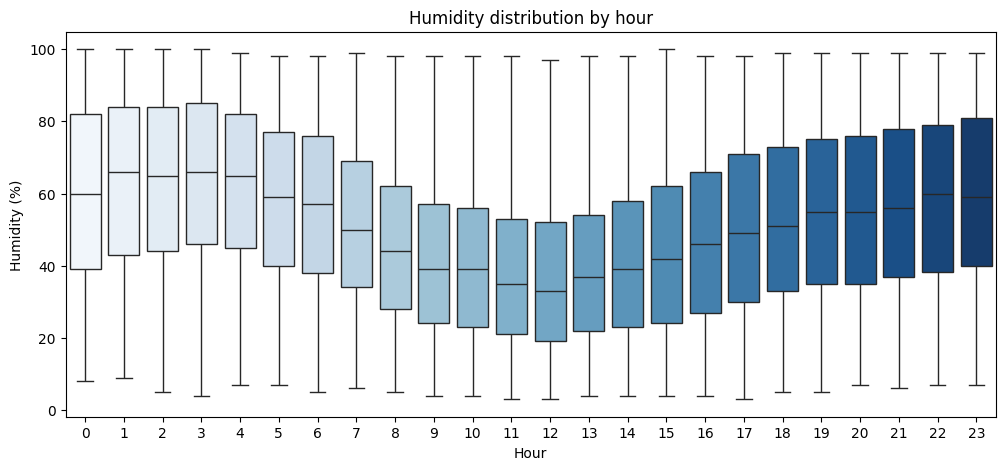

In [ ]:
from pyspark.sql.functions import month, dayofmonth, hour

weather_df = weather_df.withColumn("month", month("date_time"))
weather_df = weather_df.withColumn("day", dayofmonth("date_time"))
weather_df = weather_df.withColumn("hour", hour("date_time"))

# Convert a fresh sample for plotting engineered features
pdf_feat = weather_df.sample(False, 0.05, seed=123).toPandas()

# Boxplot of temperature by month
plt.figure(figsize=(12,5))
sns.boxplot(x="month", y="tempC", data=pdf_feat, palette="Oranges")
plt.title("Temperature distribution by month")
plt.xlabel("Month")
plt.ylabel("Temp (°C)")
plt.show()

# Boxplot of humidity by hour
plt.figure(figsize=(12,5))
sns.boxplot(x="hour", y="humidity", data=pdf_feat, palette="Blues")
plt.title("Humidity distribution by hour")
plt.xlabel("Hour")
plt.ylabel("Humidity (%)")
plt.show()

**Step 6: City-wise yearly/monthly aggregations and comparisons**

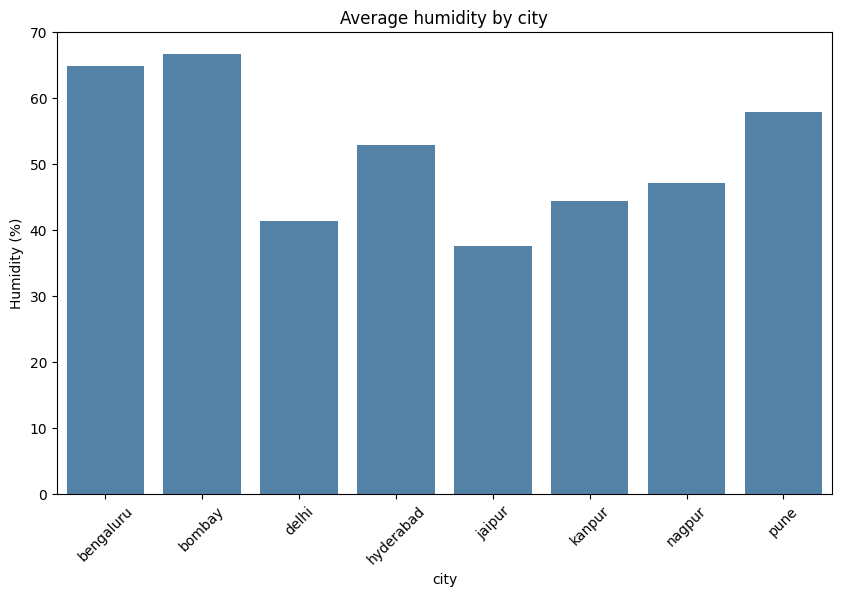

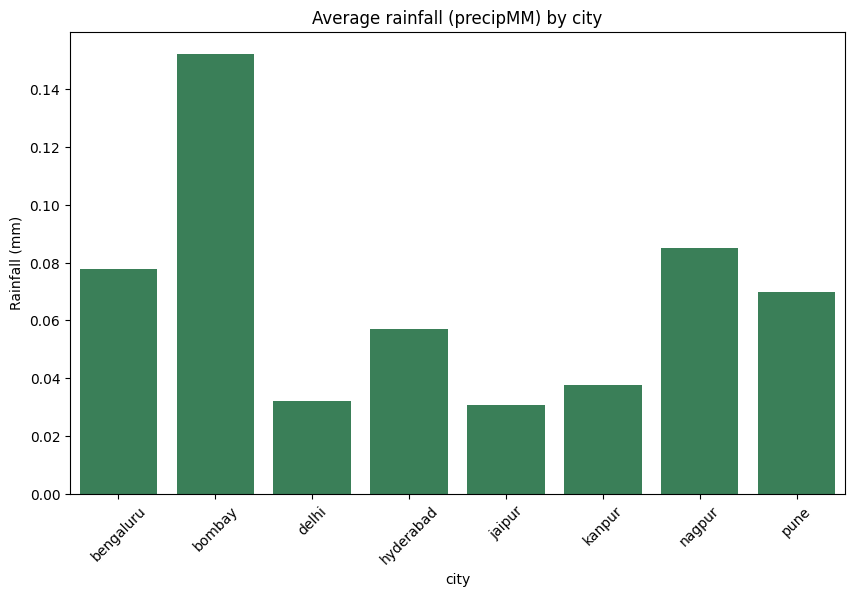

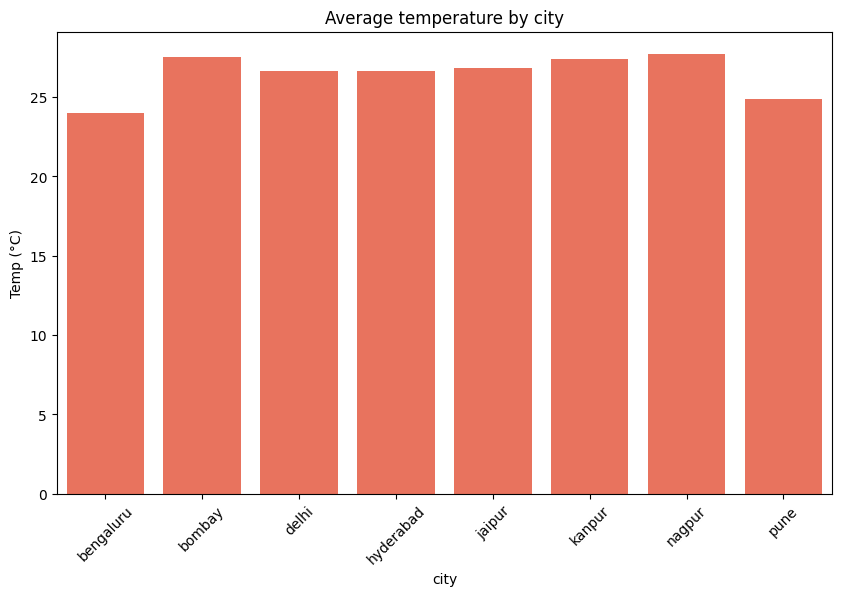

City averages (humidity_avg, rainfall_avg, temp_avg):
     city  humidity_avg  rainfall_avg  temp_avg
bengaluru     64.895460      0.077719 23.979810
   bombay     66.708914      0.152278 27.528414
    delhi     41.323254      0.032072 26.672484
hyderabad     52.876815      0.057055 26.678665
   jaipur     37.585190      0.030807 26.810353
   kanpur     44.370479      0.037756 27.429577
   nagpur     47.144921      0.085174 27.739620
     pune     57.868384      0.069972 24.867751
Highest humidity city: bombay
Highest rainfall city: bombay
Highest temperature city: nagpur


In [ ]:
from pyspark.sql.functions import year, avg, sum as spark_sum

# Yearly averages per city
yearly = weather_df.groupBy(year("date_time").alias("year"), "city").agg(
    avg("humidity").alias("humidity_avg"),
    avg("precipMM").alias("rainfall_avg"),
    avg("tempC").alias("temp_avg")
).orderBy("year","city")

pdf_yearly = yearly.toPandas()

# Bar charts: average by city (aggregating across all years present)
city_avg = weather_df.groupBy("city").agg(
    avg("humidity").alias("humidity_avg"),
    avg("precipMM").alias("rainfall_avg"),
    avg("tempC").alias("temp_avg")
).orderBy("city")
pdf_city_avg = city_avg.toPandas()

# Plot average humidity by city
plt.figure(figsize=(10,6))
sns.barplot(x="city", y="humidity_avg", data=pdf_city_avg, color="steelblue")
plt.title("Average humidity by city")
plt.xticks(rotation=45)
plt.ylabel("Humidity (%)")
plt.show()

# Plot average rainfall by city
plt.figure(figsize=(10,6))
sns.barplot(x="city", y="rainfall_avg", data=pdf_city_avg, color="seagreen")
plt.title("Average rainfall (precipMM) by city")
plt.xticks(rotation=45)
plt.ylabel("Rainfall (mm)")
plt.show()

# Plot average temperature by city
plt.figure(figsize=(10,6))
sns.barplot(x="city", y="temp_avg", data=pdf_city_avg, color="tomato")
plt.title("Average temperature by city")
plt.xticks(rotation=45)
plt.ylabel("Temp (°C)")
plt.show()

# Print numeric comparisons
print("City averages (humidity_avg, rainfall_avg, temp_avg):")
print(pdf_city_avg.sort_values("city").to_string(index=False))

# Top cities
top_humidity_city = pdf_city_avg.loc[pdf_city_avg["humidity_avg"].idxmax(), "city"]
top_rainfall_city = pdf_city_avg.loc[pdf_city_avg["rainfall_avg"].idxmax(), "city"]
top_temp_city     = pdf_city_avg.loc[pdf_city_avg["temp_avg"].idxmax(), "city"]

print("Highest humidity city:", top_humidity_city)
print("Highest rainfall city:", top_rainfall_city)
print("Highest temperature city:", top_temp_city)

**Step 7: Heatwave and heavy rainfall analysis per city**

Extreme event counts per city:
     city  heatwave_count  heavy_rain_count
bengaluru              13                 0
   bombay               0                 1
    delhi            5949                 0
hyderabad            1380                 0
   jaipur            4834                 0
   kanpur            7255                 1
   nagpur            6136                 3
     pune             165                 0
Highest heatwave count city: kanpur
Highest heavy rainfall count city: nagpur


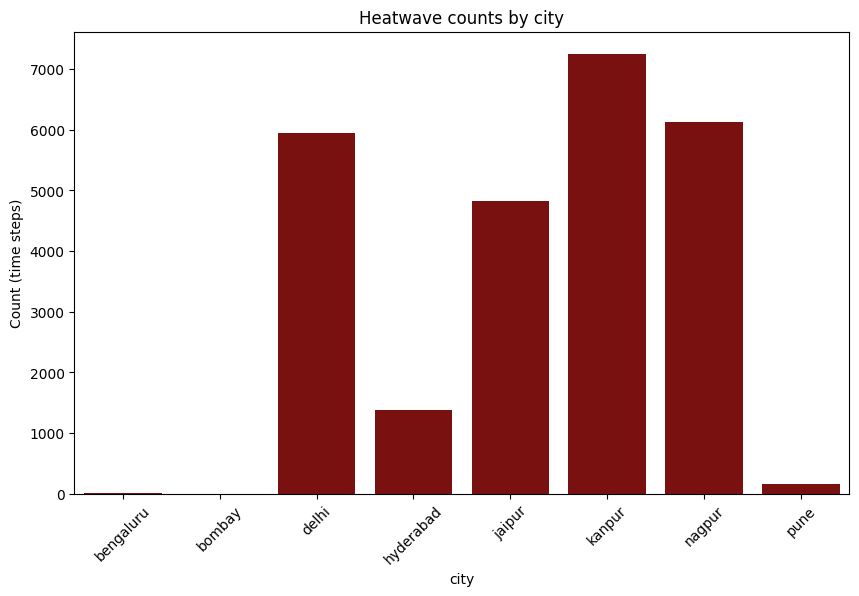

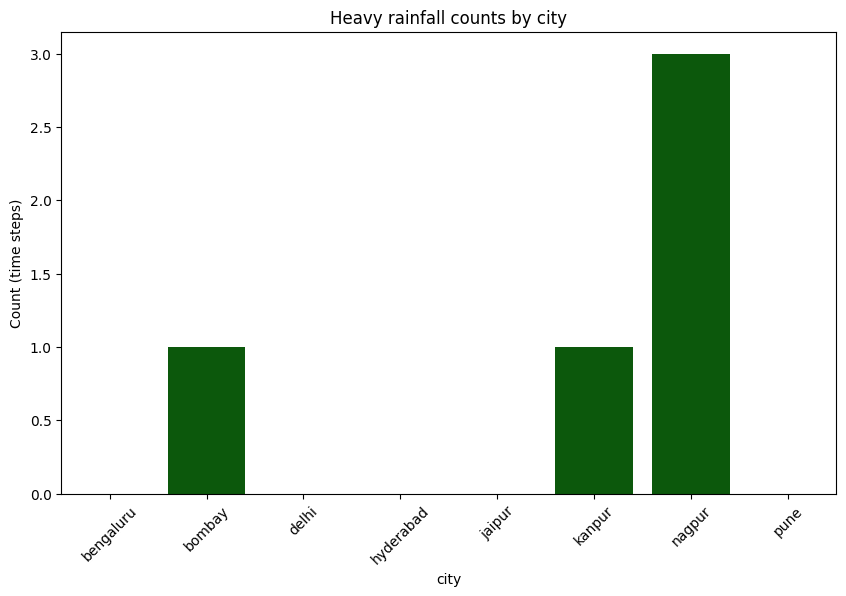

In [ ]:
from pyspark.sql.functions import when

# Define thresholds (tune these to your climate context)
HEATWAVE_TEMP = 40.0    # °C: days/hours above this considered heatwave-like
HEAVY_RAIN_MM = 20.0    # mm per time step (depends on dataset granularity)

# Heatwave flag and heavy rain flag
flagged = weather_df.withColumn("is_heatwave", when(col("tempC") >= HEATWAVE_TEMP, 1).otherwise(0)) \
                    .withColumn("is_heavy_rain", when(col("precipMM") >= HEAVY_RAIN_MM, 1).otherwise(0))

# Aggregate counts per city
extremes = flagged.groupBy("city").agg(
    spark_sum("is_heatwave").alias("heatwave_count"),
    spark_sum("is_heavy_rain").alias("heavy_rain_count")
).orderBy("city")

pdf_extremes = extremes.toPandas()

# Print counts
print("Extreme event counts per city:")
print(pdf_extremes.to_string(index=False))

# Identify top cities
top_heatwave_city = pdf_extremes.loc[pdf_extremes["heatwave_count"].idxmax(), "city"]
top_heavyrain_city = pdf_extremes.loc[pdf_extremes["heavy_rain_count"].idxmax(), "city"]

print("Highest heatwave count city:", top_heatwave_city)
print("Highest heavy rainfall count city:", top_heavyrain_city)

# Plot counts
plt.figure(figsize=(10,6))
sns.barplot(x="city", y="heatwave_count", data=pdf_extremes, color="darkred")
plt.title("Heatwave counts by city")
plt.xticks(rotation=45)
plt.ylabel("Count (time steps)")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="city", y="heavy_rain_count", data=pdf_extremes, color="darkgreen")
plt.title("Heavy rainfall counts by city")
plt.xticks(rotation=45)
plt.ylabel("Count (time steps)")
plt.show()

**Step 8: Monthly heatmaps per city (humidity and rainfall)**

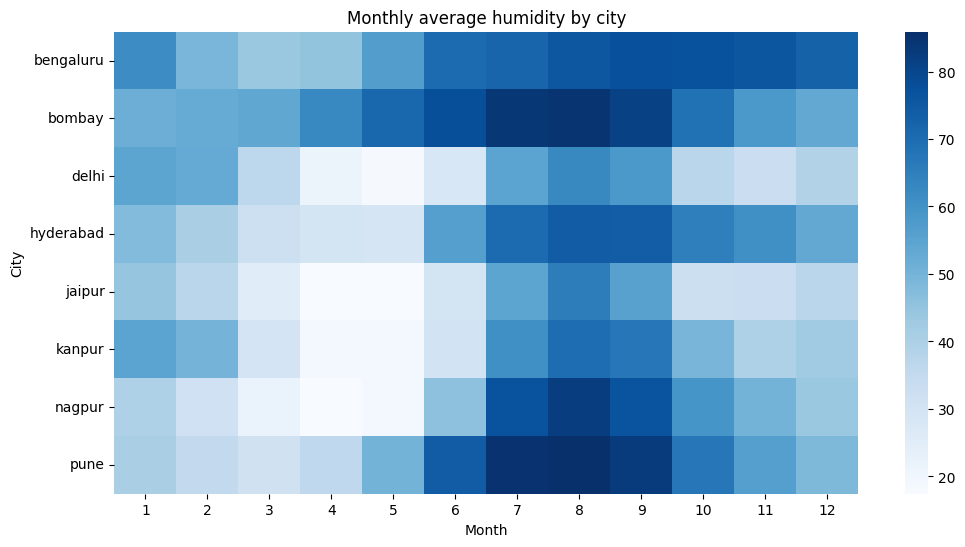

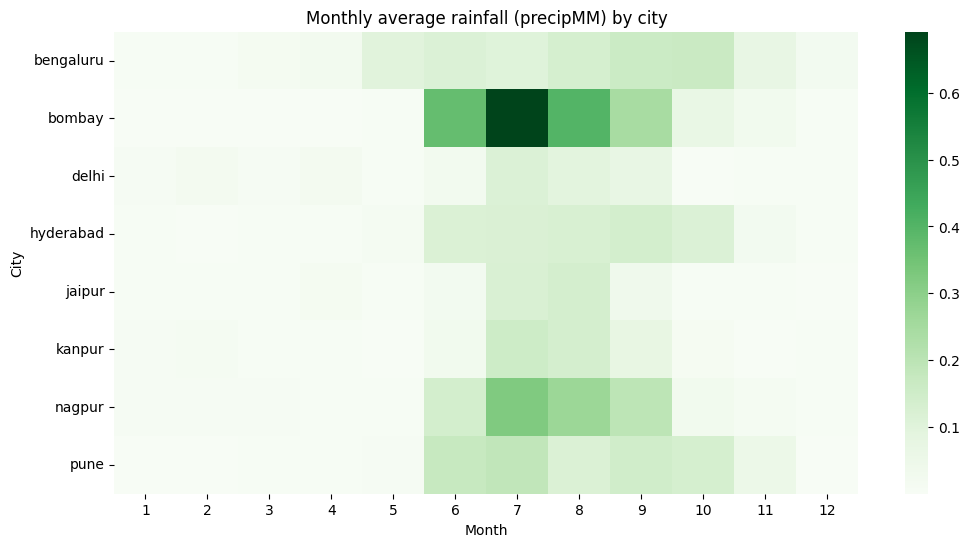

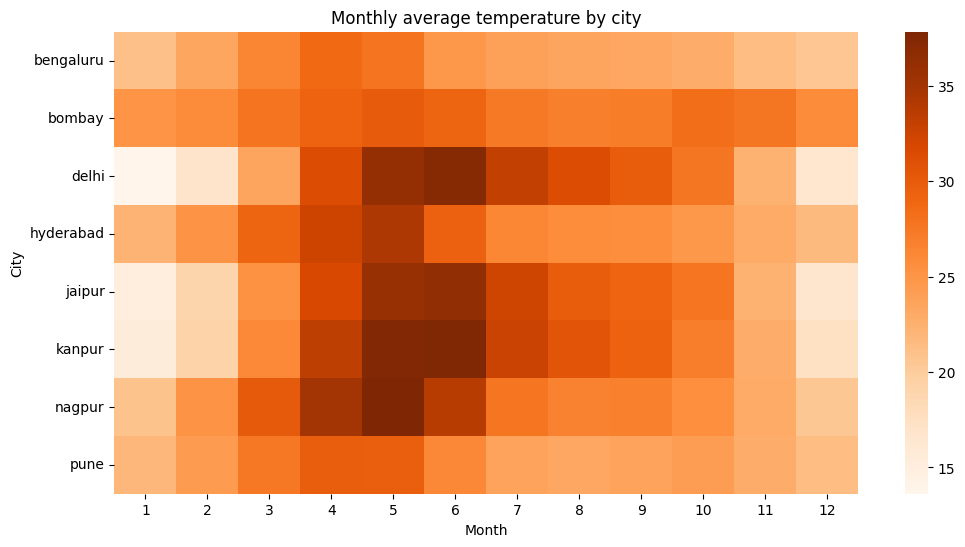

In [ ]:
# Monthly averages per city
monthly = weather_df.groupBy("city","month").agg(
    avg("humidity").alias("humidity_avg"),
    avg("precipMM").alias("rainfall_avg"),
    avg("tempC").alias("temp_avg")
).orderBy("city","month")

pdf_monthly = monthly.toPandas()

# Heatmap: humidity by month per city
pivot_h = pdf_monthly.pivot(index="city", columns="month", values="humidity_avg")
plt.figure(figsize=(12,6))
sns.heatmap(pivot_h, annot=False, cmap="Blues")
plt.title("Monthly average humidity by city")
plt.xlabel("Month")
plt.ylabel("City")
plt.show()

# Heatmap: rainfall by month per city
pivot_r = pdf_monthly.pivot(index="city", columns="month", values="rainfall_avg")
plt.figure(figsize=(12,6))
sns.heatmap(pivot_r, annot=False, cmap="Greens")
plt.title("Monthly average rainfall (precipMM) by city")
plt.xlabel("Month")
plt.ylabel("City")
plt.show()

# Heatmap: temperature by month per city
pivot_t = pdf_monthly.pivot(index="city", columns="month", values="temp_avg")
plt.figure(figsize=(12,6))
sns.heatmap(pivot_t, annot=False, cmap="Oranges")
plt.title("Monthly average temperature by city")
plt.xlabel("Month")
plt.ylabel("City")
plt.show()

**Step:9 Code for Bar Chart of Max Temperature by City**

In [ ]:
# Show one sample row per city
weather_df.groupBy("city").agg({"tempC":"max"}).show()

# Or show 5 rows per city
for c in weather_df.select("city").distinct().rdd.flatMap(lambda x: x).collect():
    print(f"--- {c} ---")
    weather_df.filter(weather_df.city == c).show(5)

+---------+----------+
|     city|max(tempC)|
+---------+----------+
|   jaipur|        48|
|    delhi|        51|
|   bombay|        38|
|bengaluru|        40|
|hyderabad|        46|
|     pune|        42|
|   kanpur|        50|
|   nagpur|        49|
+---------+----------+

--- jaipur ---
+-------------------+--------+--------+------------+-------+--------+--------+-----------------+--------+--------+--------+--------+---------+----------+----------+----------+------------+----------+--------+--------+--------+-----+----------+-------------+-------------+------+-----+---+----+-----+
|          date_time|maxtempC|mintempC|totalSnow_cm|sunHour|uvIndex5|uvIndex6|moon_illumination|moonrise| moonset| sunrise|  sunset|DewPointC|FeelsLikeC|HeatIndexC|WindChillC|WindGustKmph|cloudcover|humidity|precipMM|pressure|tempC|visibility|winddirDegree|windspeedKmph|  city|month|day|hour|label|
+-------------------+--------+--------+------------+-------+--------+--------+-----------------+--------+---

/tmp/ipython-input-71094716.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="city", y="max_tempC", data=pdf_max, palette="coolwarm")


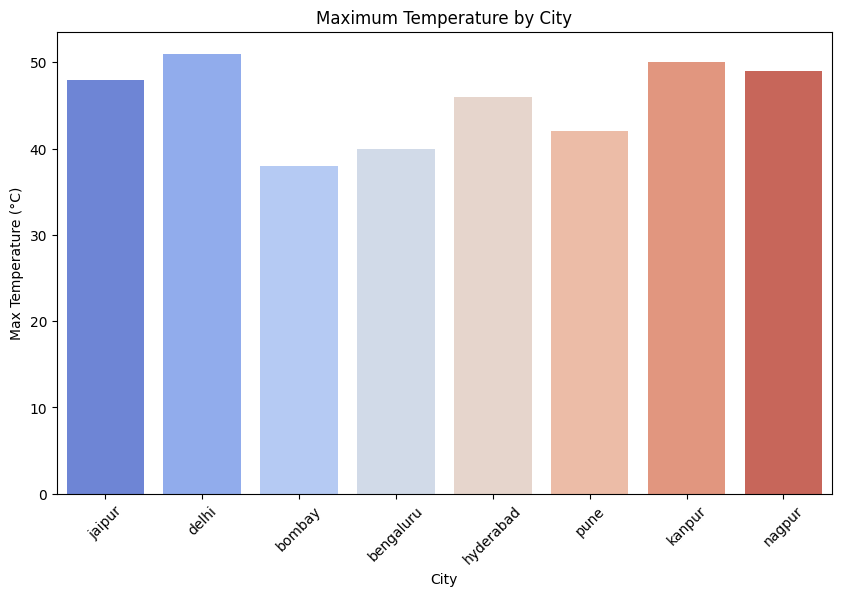

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your Spark result (max temp per city) can be converted to Pandas
city_max_temp = [
    ("jaipur", 48),
    ("delhi", 51),
    ("bombay", 38),
    ("bengaluru", 40),
    ("hyderabad", 46),
    ("pune", 42),
    ("kanpur", 50),
    ("nagpur", 49)
]

# Convert to DataFrame
pdf_max = pd.DataFrame(city_max_temp, columns=["city", "max_tempC"])

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="city", y="max_tempC", data=pdf_max, palette="coolwarm")

plt.title("Maximum Temperature by City")
plt.xlabel("City")
plt.ylabel("Max Temperature (°C)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from pyspark.sql.functions import when, col

# Create multi-class label column
weather_df = weather_df.withColumn(
    "label",
    when(col("precipMM") >= 20, 1)               # Heavy Rain
    .when(col("tempC") >= 40, 2)                 # Heatwave
    .when(col("humidity") >= 80, 3)              # High Humidity
    .otherwise(0)                                # Normal
)

# Print sample rows with labels
weather_df.select("date_time","city","tempC","humidity","precipMM","label").show(10)


+-------------------+------+-----+--------+--------+-----+
|          date_time|  city|tempC|humidity|precipMM|label|
+-------------------+------+-----+--------+--------+-----+
|2009-01-01 00:00:00|jaipur|    9|      49|     0.0|    0|
|2009-01-01 01:00:00|jaipur|    9|      50|     0.0|    0|
|2009-01-01 02:00:00|jaipur|    9|      51|     0.0|    0|
|2009-01-01 03:00:00|jaipur|    8|      52|     0.0|    0|
|2009-01-01 04:00:00|jaipur|   10|      49|     0.0|    0|
|2009-01-01 05:00:00|jaipur|   11|      46|     0.0|    0|
|2009-01-01 06:00:00|jaipur|   13|      43|     0.0|    0|
|2009-01-01 07:00:00|jaipur|   16|      38|     0.0|    0|
|2009-01-01 08:00:00|jaipur|   18|      32|     0.0|    0|
|2009-01-01 09:00:00|jaipur|   21|      26|     0.0|    0|
+-------------------+------+-----+--------+--------+-----+
only showing top 10 rows



In [ ]:
# Show some Heavy Rain rows
weather_class.filter(col("label") == 1).select("tempC","humidity","precipMM","label").show(5)

# Show some Heatwave rows
weather_class.filter(col("label") == 2).select("tempC","humidity","precipMM","label").show(5)

# Show some High Humidity rows
weather_class.filter(col("label") == 3).select("tempC","humidity","precipMM","label").show(5)

+-----+--------+--------+-----+
|tempC|humidity|precipMM|label|
+-----+--------+--------+-----+
|   27|      93|    22.5|    1|
|   29|      92|    20.6|    1|
|   31|      72|    22.9|    1|
|   29|      81|    30.6|    1|
|   24|      96|    23.6|    1|
+-----+--------+--------+-----+

+-----+--------+--------+-----+
|tempC|humidity|precipMM|label|
+-----+--------+--------+-----+
|   40|      11|     0.0|    2|
|   41|      10|     0.0|    2|
|   42|       9|     0.0|    2|
|   41|       9|     0.0|    2|
|   40|       8|     0.0|    2|
+-----+--------+--------+-----+
only showing top 5 rows

+-----+--------+--------+-----+
|tempC|humidity|precipMM|label|
+-----+--------+--------+-----+
|   11|      80|     0.0|    3|
|   11|      84|     0.0|    3|
|   10|      88|     0.0|    3|
|   12|      80|     0.0|    3|
|   11|      80|     0.0|    3|
+-----+--------+--------+-----+
only showing top 5 rows



In [ ]:
# Show distinct labels
weather_class.select("label").distinct().show()

# Count rows per label
weather_class.groupBy("label").count().show()


+-----+
|label|
+-----+
|    3|
|    2|
|    0|
|    1|
+-----+

+-----+------+
|label| count|
+-----+------+
|    3|133244|
|    2| 25732|
|    0|612475|
|    1|     5|
+-----+------+



**Step 11:Train a Classifier**

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Convert Spark DataFrame to Pandas
pdf = weather_df.select("tempC","humidity","pressure","windspeedKmph","month","hour","label").toPandas()

# Features and labels
X = pdf.drop("label", axis=1)
y = pdf["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multi-class XGBoost classifier
xgb_model = XGBClassifier(
    objective="multi:softmax",   # or "multi:softprob" for probabilities
    num_class=4,                 # 4 classes: Normal, Heavy Rain, Heatwave, High Humidity
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, ...)

**Step:12 Model Prediction**

In [ ]:
# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[122530      0      0]
 [     0   5080      0]
 [     0      0  26682]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122530
           2       1.00      1.00      1.00      5080
           3       1.00      1.00      1.00     26682

    accuracy                           1.00    154292
   macro avg       1.00      1.00      1.00    154292
weighted avg       1.00      1.00      1.00    154292



**Step 13: Evaluate Predictions**

           accuracy        f1
city                         
bengaluru  0.983161  0.653699
bombay     0.976796  0.971936
delhi      0.956040  0.850526
hyderabad  0.976202  0.791636
jaipur     0.965880  0.847826
kanpur     0.947317  0.841000
nagpur     0.943193  0.784880
pune       0.987993  0.657801


/tmp/ipython-input-889137952.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_metrics = pdf_pred.groupby("city").apply(


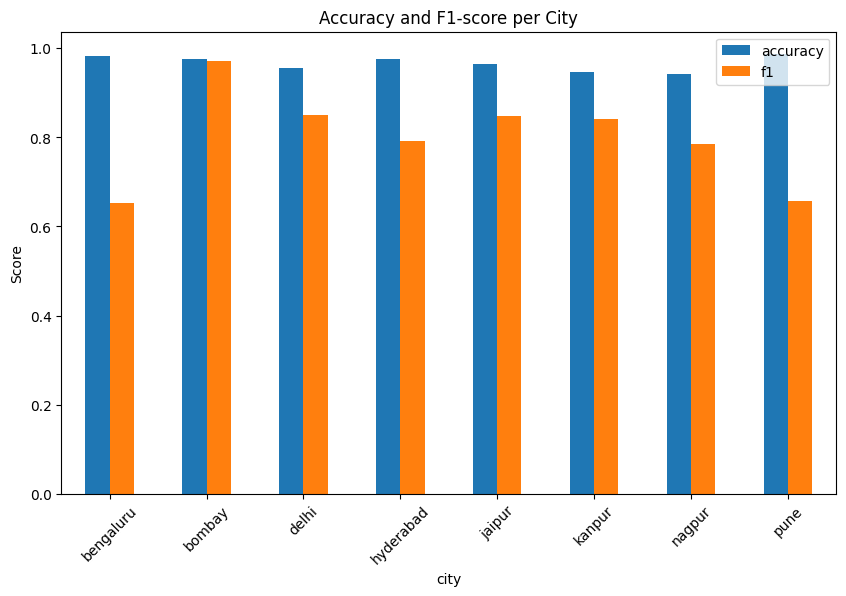

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Ensure city is included
pdf_pred = predictions.select("city","label","prediction").toPandas()

# Group by city and compute metrics
city_metrics = pdf_pred.groupby("city").apply(
    lambda df: pd.Series({
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "f1": f1_score(df["label"], df["prediction"], average="macro")
    })
)

print(city_metrics)

# Plot
city_metrics.plot(kind="bar", figsize=(10,6))
plt.title("Accuracy and F1-score per City")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

print("Accuracy: {:.2f}%".format(acc_eval.evaluate(predictions)*100))
print("F1-score: {:.2f}%".format(f1_eval.evaluate(predictions)*100))

# Confusion matrix
pdf_pred = predictions.select("label","prediction").toPandas()
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:\n", confusion_matrix(pdf_pred["label"], pdf_pred["prediction"]))
print("\nClassification Report:\n", classification_report(pdf_pred["label"], pdf_pred["prediction"]))


Accuracy: 96.70%
F1-score: 96.34%
Confusion Matrix:
 [[120742    364   1298]
 [  3037   2129      0]
 [   384      0  26100]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    122404
           2       0.85      0.41      0.56      5166
           3       0.95      0.99      0.97     26484

    accuracy                           0.97    154054
   macro avg       0.93      0.79      0.83    154054
weighted avg       0.97      0.97      0.96    154054



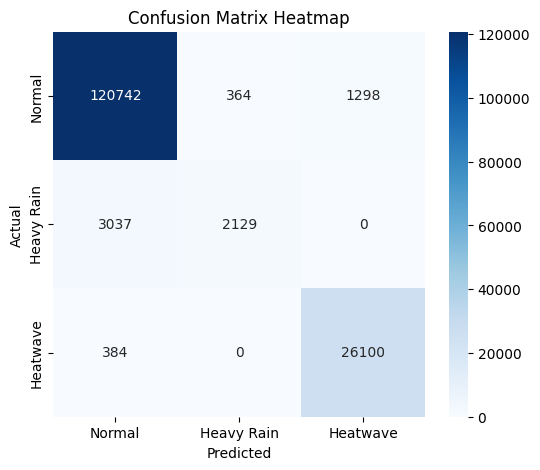

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values (from your output)
cm = np.array([[120742, 364, 1298],
               [3037, 2129, 0],
               [384, 0, 26100]])

# Define class labels
labels = ["Normal", "Heavy Rain", "Heatwave"]

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Number of rows
row_count = weather_df.count()
print("Number of rows:", row_count)

# Number of columns
col_count = len(weather_df.columns)
print("Number of columns:", col_count)

# Both together
print(f"Dataset size: {row_count} rows × {col_count} columns")


Number of rows: 771456
Number of columns: 30
Dataset size: 771456 rows × 30 columns
